# UCB algorithm 
### Recommendation system that recommends a joke based on availble ratings of some other jokes
### Jester Data: 40 jokes with their ratings in (-10,10) from 19181 Users

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
import numpy as np 
import tensorflow.compat.v1 as tf



def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
        file_name: Route of file containing the modified Jester dataset.
        context_dim: Context dimension (i.e. vector with some ratings from a user).
        num_actions: Number of actions (number of joke ratings to predict).
        num_contexts: Number of contexts to sample.
        shuffle_rows: If True, rows from original dataset are shuffled.
        shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
        dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
        opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
        
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
        
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    
    return dataset, opt_rewards, opt_actions

In [2]:
dataset, opt_rewards, opt_actions = sample_jester_data(file_name='jester_data_40jokes_19181users.npy')

### UCB

In [3]:
N = 18000
x, xr, xa =  dataset[:N], opt_rewards[:N], opt_actions[:N]
context_size = 32 # context_dim
action_size = 8 # num_actions
choices, rewards = np.zeros(N), np.zeros(N)
A = np.zeros((action_size, context_size, context_size ))
b = np.zeros((action_size,context_size))
for a in range(0, action_size):
    A[a] = np.identity(context_size)
th = np.zeros((action_size,context_size)) #parameters
p = np.zeros(action_size)

for i in range(0, N):
    xi = x[i,:context_size]
    for a in range(0, action_size):
        Ainv = np.linalg.inv(A[a])
        th[a] = Ainv.dot(b[a])
        ta = xi.dot(Ainv).dot(xi)
        a_upper = 0.2 * np.sqrt(ta)
        a_mean = th[a].dot(xi)
        p[a] = a_mean + a_upper
    p = p + (np.random.random(len(p)) + 0.00001)
    choices[i] = p.argmax()

    rewards[i] = x[i,context_size:][int(choices[i])]
    
    A[int(choices[i])] += np.outer(xi,xi)
    b[int(choices[i])] += x[i,context_size:][int(choices[i])] * xi

### Testing

In [4]:

x, xr, xa =  dataset[N:], opt_rewards[N:], opt_actions[N:]
th = np.random.random((action_size,context_size)) - 0.5 
p = np.zeros(action_size)
choices = np.zeros(len(x))
regret = []
for i in range(len(x)):
    xi = x[i,:32]
    for a in range(action_size):
        Ainv = np.linalg.inv(A[a])
        th[a] = Ainv.dot(b[a])
        a_mean = th[a].dot(xi)
        ta = xi.dot(Ainv).dot(xi)
        a_upper = 0.2 * np.sqrt(ta)
        p[a] = a_mean + a_upper
    
    p = p + (np.random.random(len(p)) + 0.00001)
    choices[i] = p.argmax()
    regret.append(np.max(x[i,32:]) - x[i,32:][int(choices[i])])


### Plots

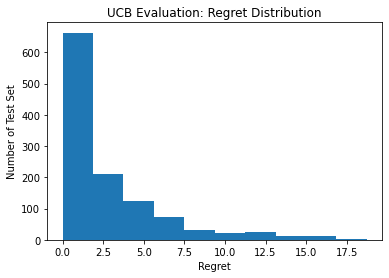

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(regret)
plt.title("UCB Evaluation: Regret Distribution", fontsize = 12)
plt.xlabel('Regret')
plt.ylabel('Number of Test Set')
plt.savefig('UCB_Jester.png',bbox_inches='tight',facecolor="#FFFFFF")
plt.show()